# Part 10. Docking

## Prepare the protein

In [17]:
## This code block imports python modules to work with during the lab, you need to run it first to get started.
# modules
import nglview
import os
import shutil
from Bio.PDB import PDBParser, PDBIO, Select,  PDBList, MMCIFParser, StructureAlignment
import Bio.Align
import os
from pathlib import Path
import rdkit

# local scripts
from scripts import viewer
from scripts import bio_align

### Download protein from the .pdb. 

The protein data bank (PDB) makes macromolecular structures publicly available. These can be used worldwide to study the 3D structures of many macromolecules. NGL viewer will be used for the molecular graphics.

[Uitleg NGL viewer]

 Make a working directory in your home directory

In [18]:
HOMEDIR = str(Path.home())
os.chdir(HOMEDIR)
# We need to check whether the directory is there
try:
    os.mkdir('Bioinformatics')
except:
    print("Directory already exists")
os.chdir('Bioinformatics')

Directory already exists


Specify the PDB code of the BACE1 protein. This will be used in the viewer to visualise the 3D structure of the protein.

In [19]:
TARGET_PDB_ID = "4djw" 

import nglview
view = nglview.show_pdbid(TARGET_PDB_ID, chain = 'A') # There are two chains, show only this one
view


NGLWidget()

For desinging drugs, it is interesting to have a closer look at the co-crystallized ligand. Therefore the residue name of ligand is needed, in this case 0KP. This is used to zoom in on the ligand. 


In [20]:
LIGAND_CODE = "0KP" 
view = nglview.show_pdbid(TARGET_PDB_ID, chain = 'A')
view
view.center(LIGAND_CODE)
view

NGLWidget()

Show the residues that are within 5 Angstrom of the ligand

In [21]:
view = nglview.show_pdbid(TARGET_PDB_ID, chain = 'A')
view.center(LIGAND_CODE)
viewer.show_residues_around(view, selection=LIGAND_CODE)
view
#[WERKT NIET]

NGLWidget()

[Have a look at the residues near the ligand, can you observe any important interactions? Describe in your report which interactions you observe, and what type of interactions they are.]

The hydrogens will be added to have a better look at the structure. The protein and ligand will be split and saved seperataly. This will be done using biopython (https://biopython.org/docs/1.75/api/Bio.html) [UITLEG WAT IS BIOPYTHON?]

Download the coordinates from RCSB.

In [22]:
pdbl = PDBList()
pdbl.retrieve_pdb_file(TARGET_PDB_ID, pdir=TARGET_PDB_ID)

Structure exists: '4djw/4djw.cif' 


'4djw/4djw.cif'

Generate a BioPython object from the coordinates

In [23]:

parser = MMCIFParser()
structure = parser.get_structure("TARGETPROT",'{}/{}.cif'.format(TARGET_PDB_ID,TARGET_PDB_ID))


/opt/conda/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6112.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6148.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6194.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6648.
  warnings.warn(


Save the ligand

In [24]:
class ResSelect(Select):
    def accept_residue(self, residue):
        if residue.get_resname() == LIGAND_CODE:
            return 1
        else:
            return 0

class NonHetSelect(Select):
    def accept_residue(self, residue):
        return 1 if residue.id[0] == " " else 0

io = PDBIO()
io.set_structure(structure)
io.save("ligand-{}.pdb".format(LIGAND_CODE), ResSelect())
io.save("protein-{}.pdb".format(TARGET_PDB_ID), NonHetSelect())

Add hydrogens to the protein, using LePro. LePro is part of the LeDock program (https://en.wikipedia.org/wiki/LeDock)
[Uitleg LePRO/LeDOCK]

In [25]:
TARGET_PDB_ID

'4djw'

In [26]:
command = '/home/jovyan/teachopencadd/teachopencadd/talktorials/MijnProject/P10_Docking/bin/lepro protein-{}.pdb'.format(TARGET_PDB_ID)
os.system(command)
shutil.move('pro.pdb','{}_prepped.pdb'.format(TARGET_PDB_ID))


'4djw_prepped.pdb'

In [27]:
# combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(TARGET_PDB_ID),
"ligand-{}.pdb".format(LIGAND_CODE)
]
with open('{}-complex.pdb'.format(TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

Show the BACE1 receptor

In [28]:
with open('{}-complex.pdb'.format(TARGET_PDB_ID)) as f:
    view = nglview.show_file(f, ext="pdb", chain = 'A') # Werkt niet
    
view.center(LIGAND_CODE)
viewer.show_residues_around(view, selection=LIGAND_CODE)
view

NGLWidget()

## Molecular docking
The molecules with the highest potency predicted by the random forest model or neuron network model will be molecular docked. This will be performed in the above prepared protein. 

In [29]:
# Install the open drug discovery toolkit (ODDT) https://oddt.readthedocs.io/en/latest/index.html
!pip install oddt
# Install vina
!pip install vina

# [Uitleg, wat zijn dit?]

In [30]:
from pymol import cmd
import py3Dmol

import pandas as pd
import glob
import sys

from vina import Vina
#import pybel

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

#from meeko import MoleculePreparation
#from meeko import obutils

import MDAnalysis as mda
from MDAnalysis.coordinates import PDB

#import prolif
#from prolif.plotting.network import LigNetwork

import nglview
from scripts import viewer

import sys, os, shutil
sys.path.insert(1, '/project/jhllei001/JHL_data/Jupyter_Dock/utilities')
# Note I had to comment out pymol, openmm and pdbfixer, hope it doesn't break later
#from utils import fix_protein, getbox, generate_ledock_file, pdbqt_to_sdf, dok_to_sdf

import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

Make an environment to work in and put in some files:

In [31]:
from pathlib import Path
HOMEDIR = str(Path.home())
os.chdir(HOMEDIR)
# We need to check whether the directory is there
try:
    os.mkdir('Docking')
except:
    print("Directory already exists")
os.chdir('Docking')

Directory already exists


#### Feching system and cleanup

Copy the prepared protein

In [42]:
PDBCODE = '4djw' 
LIGAND_CODE = '0KP' 
shutil.copy('../Bioinformatics/{}_prepped.pdb'.format(PDBCODE), '{}_prepped.pdb'.format(PDBCODE)) 
shutil.copy('../Bioinformatics/ligand-{}.pdb'.format(LIGAND_CODE), 'ligand-{}.pdb'.format(LIGAND_CODE))

'ligand-0KP.pdb'

The smiles of the ligand with the highest predicted pIC50 by the random forest model and neuron network model are added to test_smiles. The 3D coordinate files of each of these ligands will be generated. 

In [37]:
test_smiles = [
    'COc1ccc(C(=O)Nc2ccc(F)c(C3(C)CS(=O)(=O)C(C)(C)C(N)=N3)c2)nc1',# Top1RandomForest
    'NC1=NC(c2cc(NC(=O)c3ncc(Cl)cc3Cl)ccc2F)(C(F)F)OCC1'# Top1NeuronNetwork (Nu enkel een dummy, vul jouwe in)
]

The 3D files will be generated using rdkit. Th ligands get automatic number added, so they will be called ligand_00 (for the ligand with the highest potency predicted by the random forest model) and ligand_01 (for the ligand with the higest potency predicited by the neuron network model).

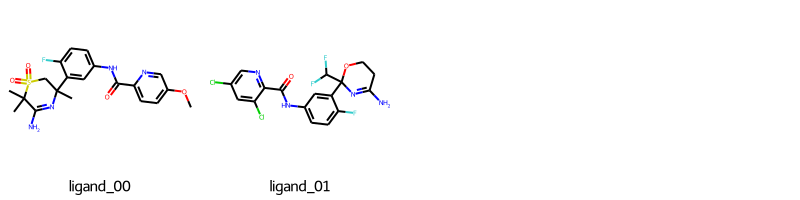

In [38]:
i = -1

IDs = []
for i in range(0,len(test_smiles)):
    base = 'ligand_{:02d}'.format(i)
    IDs.append(base)
    
df = pd.DataFrame({'ID':IDs, 'SMILES':test_smiles})

df['rdkit_mol'] = [Chem.MolFromSmiles(s) for s in df['SMILES']]

# Generate 2D images of the molecules
img=Draw.MolsToGridImage(df['rdkit_mol'].tolist(),
                            molsPerRow=4,
                            subImgSize=(200,200),
                            legends=df['ID'].tolist())

for i in range(len(df)):
    row = df.iloc[i]
    mol = row['rdkit_mol']
    name = row['ID'] + '.mol'
    Chem.MolToMolFile(mol,name)

img


From the above visualised ligands are mol2 files saved to be used for the next docking steps. 

#### System Visualization

Show the structure with ligand_00

In [43]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})


view.addModel(open('../Bioinformatics/{}_prepped.pdb'.format(PDBCODE),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})


view.addModel(open('ligand_00.mol','r').read(),format='mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModelsAsFrames(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The crystalised ligand are visualised in magenta and novel ligand_00 is shown in green. As can be seen is the novel ligand not in the binding site. This is because the coordinate information is missing. Therefore, the ligand will be redocked in the protein binding site. 

#### Docking with AutoDock Vina

AutoDock Vina (Vina) will be used as docking engines, as it is widely used, fast and open source. 

##### Protein and ligand preparation

After sanitization, the protein docking preparation includes converting it to the PDBQT file format, which stores the atomic coordinates, partial charges, and AutoDock atom types for both the receptor and the ligand.

[Wat doet onderstaande code? Algemeen]

In [44]:
from math import isnan, isinf

def PDBQTAtomLines(mol, donors, acceptors):
    """Create a list with PDBQT atom lines for each atom in molecule. Donors
    and acceptors are given as a list of atom indices.
    """

    atom_lines = [line.replace('HETATM', 'ATOM  ')
                  for line in Chem.MolToPDBBlock(mol).split('\n')
                  if line.startswith('HETATM') or line.startswith('ATOM')]

    pdbqt_lines = []
    for idx, atom in enumerate(mol.GetAtoms()):
        pdbqt_line = atom_lines[idx][:56]

        pdbqt_line += '0.00  0.00    '  # append empty vdW and ele
        # Get charge
        charge = 0.
        fields = ['_MMFF94Charge', '_GasteigerCharge', '_TriposPartialCharge']
        for f in fields:
            if atom.HasProp(f):
                charge = atom.GetDoubleProp(f)
                break
        # FIXME: this should not happen, blame RDKit
        if isnan(charge) or isinf(charge):
            charge = 0.
        pdbqt_line += ('%.3f' % charge).rjust(6)

        # Get atom type
        pdbqt_line += ' '
        atomicnum = atom.GetAtomicNum()
        if atomicnum == 6 and atom.GetIsAromatic():
            pdbqt_line += 'A'
        elif atomicnum == 7 and idx in acceptors:
            pdbqt_line += 'NA'
        elif atomicnum == 8 and idx in acceptors:
            pdbqt_line += 'OA'
        elif atomicnum == 1 and atom.GetNeighbors()[0].GetIdx() in donors:
            pdbqt_line += 'HD'
        else:
            pdbqt_line += atom.GetSymbol()
        pdbqt_lines.append(pdbqt_line)
    return pdbqt_lines

def MolToPDBQTBlock(mol, flexible=True, addHs=False, computeCharges=False):
    """Write RDKit Molecule to a PDBQT block

    Parameters
    ----------
        mol: rdkit.Chem.rdchem.Mol
            Molecule with a protein ligand complex
        flexible: bool (default=True)
            Should the molecule encode torsions. Ligands should be flexible,
            proteins in turn can be rigid.
        addHs: bool (default=False)
            The PDBQT format requires at least polar Hs on donors. By default Hs
            are added.
        computeCharges: bool (default=False)
            Should the partial charges be automatically computed. If the Hs are
            added the charges must and will be recomputed. If there are no
            partial charge information, they are set to 0.0.

    Returns
    -------
        block: str
            String wit PDBQT encoded molecule
    """
    # make a copy of molecule
    mol = Chem.Mol(mol)

    # if flexible molecule contains multiple fragments write them separately
    if flexible and len(Chem.GetMolFrags(mol)) > 1:
        return ''.join(MolToPDBQTBlock(frag, flexible=flexible, addHs=addHs,
                                       computeCharges=computeCharges)
                       for frag in Chem.GetMolFrags(mol, asMols=True))

    # Identify donors and acceptors for atom typing
    # Acceptors
    patt = Chem.MolFromSmarts('[$([O;H1;v2]),'
                              '$([O;H0;v2;!$(O=N-*),'
                              '$([O;-;!$(*-N=O)]),'
                              '$([o;+0])]),'
                              '$([n;+0;!X3;!$([n;H1](cc)cc),'
                              '$([$([N;H0]#[C&v4])]),'
                              '$([N&v3;H0;$(Nc)])]),'
                              '$([F;$(F-[#6]);!$(FC[F,Cl,Br,I])])]')
    acceptors = list(map(lambda x: x[0],
                         mol.GetSubstructMatches(patt, maxMatches=mol.GetNumAtoms())))
    # Donors
    patt = Chem.MolFromSmarts('[$([N&!H0&v3,N&!H0&+1&v4,n&H1&+0,$([$([Nv3](-C)(-C)-C)]),'
                              '$([$(n[n;H1]),'
                              '$(nc[n;H1])])]),'
                              # Guanidine can be tautormeic - e.g. Arginine
                              '$([NX3,NX2]([!O,!S])!@C(!@[NX3,NX2]([!O,!S]))!@[NX3,NX2]([!O,!S])),'
                              '$([O,S;H1;+0])]')
    donors = list(map(lambda x: x[0],
                      mol.GetSubstructMatches(patt, maxMatches=mol.GetNumAtoms())))
    if addHs:
        mol = Chem.AddHs(mol, addCoords=True, onlyOnAtoms=donors, )
    if addHs or computeCharges:
        AllChem.ComputeGasteigerCharges(mol)

    atom_lines = PDBQTAtomLines(mol, donors, acceptors)
    assert len(atom_lines) == mol.GetNumAtoms()

    pdbqt_lines = []

    # vina scores
    if (mol.HasProp('vina_affinity') and mol.HasProp('vina_rmsd_lb') and
            mol.HasProp('vina_rmsd_lb')):
        pdbqt_lines.append('REMARK VINA RESULT:  ' +
                           ('%.1f' % float(mol.GetProp('vina_affinity'))).rjust(8) +
                           ('%.3f' % float(mol.GetProp('vina_rmsd_lb'))).rjust(11) +
                           ('%.3f' % float(mol.GetProp('vina_rmsd_ub'))).rjust(11))

    pdbqt_lines.append('REMARK  Name = ' +
                       (mol.GetProp('_Name') if mol.HasProp('_Name') else ''))
    if flexible:
        # Find rotatable bonds
        rot_bond = Chem.MolFromSmarts('[!$(*#*)&!D1&!$(C(F)(F)F)&'
                                      '!$(C(Cl)(Cl)Cl)&'
                                      '!$(C(Br)(Br)Br)&'
                                      '!$(C([CH3])([CH3])[CH3])&'
                                      '!$([CD3](=[N,O,S])-!@[#7,O,S!D1])&'
                                      '!$([#7,O,S!D1]-!@[CD3]=[N,O,S])&'
                                      '!$([CD3](=[N+])-!@[#7!D1])&'
                                      '!$([#7!D1]-!@[CD3]=[N+])]-!@[!$(*#*)&'
                                      '!D1&!$(C(F)(F)F)&'
                                      '!$(C(Cl)(Cl)Cl)&'
                                      '!$(C(Br)(Br)Br)&'
                                      '!$(C([CH3])([CH3])[CH3])]')
        bond_atoms = list(mol.GetSubstructMatches(rot_bond))
        num_torsions = len(bond_atoms)

        # Active torsions header
        pdbqt_lines.append('REMARK  %i active torsions:' % num_torsions)
        pdbqt_lines.append('REMARK  status: (\'A\' for Active; \'I\' for Inactive)')
        for i, (a1, a2) in enumerate(bond_atoms):
            pdbqt_lines.append('REMARK%5.0i  A    between atoms: _%i  and  _%i'
                               % (i + 1, a1 + 1, a2 + 1))

        # Fragment molecule on bonds to ge rigid fragments
        bond_ids = [mol.GetBondBetweenAtoms(a1, a2).GetIdx()
                    for a1, a2 in bond_atoms]
        if bond_ids:
            mol_rigid_frags = Chem.FragmentOnBonds(mol, bond_ids, addDummies=False)
        else:
            mol_rigid_frags = mol
        frags = list(Chem.GetMolFrags(mol_rigid_frags))

        def weigh_frags(frag):
            """sort by the fragment size and the number of bonds (secondary)"""
            num_bonds = 0
            # bond_weight = 0
            for a1, a2 in bond_atoms:
                if a1 in frag or a2 in frag:
                    num_bonds += 1
                    # for frag2 in frags:
                    #     if a1 in frag2 or a2 in frag2:
                    #         bond_weight += len(frag2)

            # changed signs are fixing mixed sorting type (ascending/descending)
            return -len(frag), -num_bonds,  # bond_weight
        frags = sorted(frags, key=weigh_frags)

        # Start writting the lines with ROOT
        pdbqt_lines.append('ROOT')
        frag = frags.pop(0)
        for idx in frag:
            pdbqt_lines.append(atom_lines[idx])
        pdbqt_lines.append('ENDROOT')

        # Now build the tree of torsions usign DFS algorithm. Keep track of last
        # route with following variables to move down the tree and close branches
        branch_queue = []
        current_root = frag
        old_roots = [frag]

        visited_frags = []
        visited_bonds = []
        while len(frags) > len(visited_frags):
            end_branch = True
            for frag_num, frag in enumerate(frags):
                for bond_num, (a1, a2) in enumerate(bond_atoms):
                    if (frag_num not in visited_frags and
                        bond_num not in visited_bonds and
                        (a1 in current_root and a2 in frag or
                         a2 in current_root and a1 in frag)):
                        # direction of bonds is important
                        if a1 in current_root:
                            bond_dir = '%i %i' % (a1 + 1, a2 + 1)
                        else:
                            bond_dir = '%i %i' % (a2 + 1, a1 + 1)
                        pdbqt_lines.append('BRANCH %s' % bond_dir)
                        for idx in frag:
                            pdbqt_lines.append(atom_lines[idx])
                        branch_queue.append('ENDBRANCH %s' % bond_dir)

                        # Overwrite current root and stash previous one in queue
                        old_roots.append(current_root)
                        current_root = frag

                        # remove used elements from stack
                        visited_frags.append(frag_num)
                        visited_bonds.append(bond_num)

                        # mark that we dont want to end branch yet
                        end_branch = False
                        break
                    else:
                        continue
                    break  # break the outer loop as well

            if end_branch:
                pdbqt_lines.append(branch_queue.pop())
                if old_roots:
                    current_root = old_roots.pop()
        # close opened branches if any is open
        while len(branch_queue):
            pdbqt_lines.append(branch_queue.pop())
        pdbqt_lines.append('TORSDOF %i' % num_torsions)
    else:
        pdbqt_lines.extend(atom_lines)

    return '\n'.join(pdbqt_lines)

def MolFromPDBQTBlock(filename, sanitize=True, removeHs=True):
    """Read PDBQT block to a RDKit Molecule
    Parameters
    ----------
        block: string
            Residue name which explicitly pint to a ligand(s).
        sanitize: bool (default=True)
            Should the sanitization be performed
        removeHs: bool (default=True)
            Should hydrogens be removed when reading molecule.
    Returns
    -------
        mol: rdkit.Chem.rdchem.Mol
            Molecule read from PDBQT
    """
    pdb_lines = []
    name = ''
    data = {}
    with open(filename) as file:
        lines = file.readlines()
        block = [line.rstrip() for line in lines]
        
    for line in block: #.split('\n'):
        # Get all know data from REMARK section
        if line[:12] == 'REMARK  Name':
            name = line[15:].strip()
        elif line[:18] == 'REMARK VINA RESULT':
            tmp = line[19:].split()
            data['vina_affinity'] = tmp[0]
            data['vina_rmsd_lb'] = tmp[1]
            data['vina_rmsd_ub'] = tmp[2]

        # no more data to collect
        if line[:4] != 'ATOM':
            continue

        pdb_line = line[:56]
        pdb_line += '1.00  0.00           '

        # Do proper atom type lookup
        atom_type = line[71:].split()[1]
        if atom_type == 'A':
            atom_type = 'C'
        elif atom_type[:1] == 'O':
            atom_type = 'O'
        elif atom_type[:1] == 'H':
            atom_type = 'H'
            if removeHs:
                continue
        elif atom_type == 'NA':
            atom_type = 'N'

        pdb_lines.append(pdb_line + atom_type)
    mol = Chem.MolFromPDBBlock('\n'.join(pdb_lines), sanitize=False)
    if sanitize:
        Chem.SanitizeMol(mol)
    else:
        Chem.GetSSSR(mol)
    # reorder atoms using serial
    new_order = sorted(range(mol.GetNumAtoms()),
                       key=lambda i: (mol.GetAtomWithIdx(i)
                                      .GetPDBResidueInfo()
                                      .GetSerialNumber()))
    mol = Chem.RenumberAtoms(mol, new_order)

    # properties must be set on final copy of Mol, RenumberAtoms purges data
    mol.SetProp('_Name', name)
    for k, v in data.items():
        mol.SetProp(str(k), str(v))

    return mol

Using radius of gyration can an efficient box be generated for the docking process. The radius of gyration and center of geometry of the ligand will be calculated to define the box size. 

[Meer uitleg?]

In [45]:
import math

def Rg(filename):
    '''
    Calculates the Radius of Gyration (Rg) of a protein given its .pdb 
    structure file. Returns the Rg integer value in Angstrom.
    '''
    coord = list()
    mass = list()
    Structure = open(filename, 'r')
    for line in Structure:
        try:
            line = line.split()
            x = float(line[6])
            y = float(line[7])
            z = float(line[8])
            coord.append([x, y, z])
            if line[-1] == 'C':
                mass.append(12.0107)
            elif line[-1] == 'O':
                mass.append(15.9994)
            elif line[-1] == 'N':
                mass.append(14.0067)
            elif line[-1] == 'S':
                mass.append(32.065)
        except:
            pass
    xm = [(m*i, m*j, m*k) for (i, j, k), m in zip(coord, mass)]
    tmass = sum(mass)
    rr = sum(mi*i + mj*j + mk*k for (i, j, k), (mi, mj, mk) in zip(coord, xm))
    mm = sum((sum(i) / tmass)**2 for i in zip(*xm))
    rg = math.sqrt(rr / tmass-mm)
    return(round(rg, 3))

# Calculate the center based on the reference ligand
Rg = Rg('ligand-{}.pdb'.format(LIGAND_CODE))
print("Radius of Gyration = {}".format(Rg))

Radius of Gyration = 21.357


In [46]:
# Calculate center of geometry
def COG(pdbfile, include='ATOM,HETATM'):
    """
    Calculates center of geometry of a protein and/or ligand structure.
    Returns:
        center (list): List of float coordinates [x,y,z] that represent the
        center of geometry (precision 3).
    """

    center = [None, None, None]
    include = tuple(include.split(','))

    with open(pdbfile) as pdb:

        # extract coordinates [ [x1,y1,z1], [x2,y2,z2], ... ]
        coordinates = []
        for line in pdb:
            if line.startswith(include):
                coordinates.append([float(line[30:38]),    # x_coord
                                    float(line[38:46]),    # y_coord
                                    float(line[46:54])     # z_coord
                                   ])

        # calculate center of geometry
        center = [sum([coordinates[i][j]/(len(coordinates))
              for i in range(len(coordinates))]) for j in range(3)]
        center = [round(center[i], 3) for i in range(3)]
    return center

CenterOfGeometry = COG('ligand-{}.pdb'.format(LIGAND_CODE))
print("Center Of Geometry = {}".format(CenterOfGeometry))

Center Of Geometry = [21.542, 22.699, 38.449]


#### Docking

Run docking on each of the ligands seperatly and visually inspect the results. 

##### Ligand_00

Prepare the protein and ligand

In [47]:
protein = Chem.MolFromPDBFile('../Bioinformatics/{}_prepped.pdb'.format(PDBCODE))
a = MolToPDBQTBlock(protein,flexible=False)
with open('protein.pdbqt','w') as outfile:
    for line in a:
        outfile.write(line)

In [48]:
LIGAND_TO_DOCK = 'ligand_00' # Write the ligand you want to dock here.
m = Chem.MolFromMolFile('{}.mol'.format(LIGAND_TO_DOCK))
a = MolToPDBQTBlock(m)
with open('{}.pdbqt'.format(LIGAND_TO_DOCK), 'w') as outfile:
    for line in a:
        outfile.write(line)

Perform the docking (This can take a while)

[Uitleg hoe werkt deze docking?]

In [49]:
v = Vina(sf_name='vina')

v.set_receptor('protein.pdbqt')

v.set_ligand_from_file('{}.pdbqt'.format(LIGAND_TO_DOCK))

center = {
     'center_x' : CenterOfGeometry[0], 
     'center_y' : CenterOfGeometry[1], 
     'center_z' : CenterOfGeometry[2]
     
}

size = { 
    'size_x' : Rg * 2.9 ,
    'size_y' : Rg * 2.9,
    'size_z' : Rg * 2.9,           
           }
 

v.compute_vina_maps(center=[center['center_x'], center['center_y'], center['center_z']], 
                    box_size=[size['size_x'], size['size_y'], size['size_z']])

'''
# Score the current pose
energy = v.score()
print('Score before minimization: %.3f (kcal/mol)' % energy[0])

# Minimized locally the current pose
energy_minimized = v.optimize()
print('Score after minimization : %.3f (kcal/mol)' % energy_minimized[0])
v.write_pose('1iep_ligand_minimized.pdbqt', overwrite=True)
'''

# Dock the ligand
v.dock(exhaustiveness=10, n_poses=10)
v.write_poses('docking_results.pdbqt', n_poses=1, overwrite=True)

Computing Vina grid ... done.
Performing docking (random seed: -1094215811) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


In [50]:
# Create a mol object from the docking results, write the mol to file and print the predicted affinity
mol = MolFromPDBQTBlock('docking_results.pdbqt',sanitize=False)
Chem.rdmolfiles.MolToPDBFile(mol, '{}_docked.pdb'.format(LIGAND_TO_DOCK))
Ki = (math.exp(float(mol.GetProp('vina_affinity'))/0.592))
pKi = -math.log10(Ki)
pChEMBL = pKi
print('The affinity predicted by Vina = {} (kcal/mol)'.format(mol.GetProp('vina_affinity')))
print('Which (approximately) corresponds to a pChEMBL of {:.2f}'.format(pKi))

# Kan de Ki vervangen worden door IC50?

The affinity predicted by Vina = -8.302 (kcal/mol)
Which (approximately) corresponds to a pChEMBL of 6.09


3D visualization of docking results

In [53]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('../Bioinformatics/{}_prepped.pdb'.format(PDBCODE),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = '{}_docked.pdb'.format(LIGAND_TO_DOCK)
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Reference: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()

Reference: Magenta | Vina Pose: Cyan


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The novel ligand_00 binds on the same place as the reference ligand. However, the residuals are in somewhat different direction. 

Add a nglviewer to show key interactions

In [54]:
# combine protein and ligand files
filenames = [
'../Bioinformatics/{}_prepped.pdb'.format(PDBCODE),
'{}_docked.pdb'.format(LIGAND_TO_DOCK)
]
with open('{}-complex.pdb'.format(PDBCODE), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

In [55]:
docktmp = '{}_docked.pdb'.format(LIGAND_TO_DOCK)

with open('{}-complex.pdb'.format(PDBCODE)) as f:
    view = nglview.show_file(f, ext="pdb")
    
view.center("UNL")
viewer.show_residues_around(view, selection="UNL")
view

NGLWidget()

In above viewer can be seen that the novel ligand_00 can have interaction with the residuals of the protein, like H-bonds with the nitrogen and oxygen atoms of the ligand. 

##### Ligand_01

Prepare the protein and ligand

In [57]:
protein = Chem.MolFromPDBFile('../Bioinformatics/{}_prepped.pdb'.format(PDBCODE))
a = MolToPDBQTBlock(protein,flexible=False)
with open('protein.pdbqt','w') as outfile:
    for line in a:
        outfile.write(line)

In [58]:
LIGAND_TO_DOCK = 'ligand_01' # Write the ligand you want to dock here.
m = Chem.MolFromMolFile('{}.mol'.format(LIGAND_TO_DOCK))
a = MolToPDBQTBlock(m)
with open('{}.pdbqt'.format(LIGAND_TO_DOCK), 'w') as outfile:
    for line in a:
        outfile.write(line)

Perform the docking 

In [59]:
v = Vina(sf_name='vina')

v.set_receptor('protein.pdbqt')

v.set_ligand_from_file('{}.pdbqt'.format(LIGAND_TO_DOCK))

center = {
     'center_x' : CenterOfGeometry[0], 
     'center_y' : CenterOfGeometry[1], 
     'center_z' : CenterOfGeometry[2]
     
}

size = { 
    'size_x' : Rg * 2.9 ,
    'size_y' : Rg * 2.9,
    'size_z' : Rg * 2.9,           
           }
 

v.compute_vina_maps(center=[center['center_x'], center['center_y'], center['center_z']], 
                    box_size=[size['size_x'], size['size_y'], size['size_z']])

'''
# Score the current pose
energy = v.score()
print('Score before minimization: %.3f (kcal/mol)' % energy[0])

# Minimized locally the current pose
energy_minimized = v.optimize()
print('Score after minimization : %.3f (kcal/mol)' % energy_minimized[0])
v.write_pose('1iep_ligand_minimized.pdbqt', overwrite=True)
'''

# Dock the ligand
v.dock(exhaustiveness=10, n_poses=10)
v.write_poses('docking_results.pdbqt', n_poses=1, overwrite=True)


mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.302          0          0
   2       -8.182       2.22      2.651
   3       -8.047      1.533      1.726
   4        -7.84       2.18      2.976
   5       -7.812      40.35      42.39
   6       -7.737      3.068      8.966
   7       -7.673      3.885      9.411
   8       -7.631      4.725      5.228
   9       -7.583      3.606      9.531
  10       -7.466      2.823      8.859
Computing Vina grid ... done.
Performing docking (random seed: -1817065363) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


In [60]:
# Create a mol object from the docking results, write the mol to file and print the predicted affinity
mol = MolFromPDBQTBlock('docking_results.pdbqt',sanitize=False)
Chem.rdmolfiles.MolToPDBFile(mol, '{}_docked.pdb'.format(LIGAND_TO_DOCK))
Ki = (math.exp(float(mol.GetProp('vina_affinity'))/0.592))
pKi = -math.log10(Ki)
pChEMBL = pKi
print('The affinity predicted by Vina = {} (kcal/mol)'.format(mol.GetProp('vina_affinity')))
print('Which (approximately) corresponds to a pChEMBL of {:.2f}'.format(pKi))

# Kan de Ki vervangen worden door IC50?

The affinity predicted by Vina = -8.157 (kcal/mol)
Which (approximately) corresponds to a pChEMBL of 5.98


3D visualization of docking results

In [61]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('../Bioinformatics/{}_prepped.pdb'.format(PDBCODE),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = '{}_docked.pdb'.format(LIGAND_TO_DOCK)
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Reference: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()

Reference: Magenta | Vina Pose: Cyan


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

[Uitleg wat te zien]

Add a nglviewer to show key interactions

In [62]:
# combine protein and ligand files
filenames = [
'../Bioinformatics/{}_prepped.pdb'.format(PDBCODE),
'{}_docked.pdb'.format(LIGAND_TO_DOCK)
]
with open('{}-complex.pdb'.format(PDBCODE), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

In [63]:
docktmp = '{}_docked.pdb'.format(LIGAND_TO_DOCK)

with open('{}-complex.pdb'.format(PDBCODE)) as f:
    view = nglview.show_file(f, ext="pdb")
    
view.center("UNL")
viewer.show_residues_around(view, selection="UNL")
view

NGLWidget()

This interactions between ligand_01 and the protein are shown in the viewer above. 